# Internship Project: *Retail AI*

Learning PDFs and Resources can be found at: [Github Repository](https://www.github.com/rujuldwivedi/Internship)

## Model Training & Evaluation

This notebook is a continuation of the **Data Augmentation** step. Here, we train machine learning models to classify retail products efficiently.

### Objectives:
- Train a machine learning model using the preprocessed data.
- Evaluate model performance using accuracy and classification metrics.
- Identify important features influencing the classification results.

### This step is only for Google Colab

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required Libraries

In [36]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import ipywidgets as widgets
from IPython.display import display

### Declare the path of the dataset

In [37]:
# Declare the file path
file_path = '/content/drive/My Drive/Internship/sampled_dataset.csv'

### Load dataset (replace with 'dataset.csv' as required)

In [38]:
# Load dataset
data = pd.read_csv(file_path)

### Sample the data (To ease off the computation time for the model)
The full model can be trained the original dataset in High Performance Computing (HPC) environments

In [39]:
# Sample the data
data = data.sample(frac=0.1, random_state=10)

### Display basic information

In [40]:
# Display basic information
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 32480 entries, 37538 to 160665
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   main_category  32480 non-null  object
 1   title          32480 non-null  object
 2   description    32480 non-null  object
 3   images         32480 non-null  object
 4   details        32480 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB
                    main_category  \
37538   Cell Phones & Accessories   
124693               Toys & Games   
249067                Amazon Home   
103904   Tools & Home Improvement   
126448  Cell Phones & Accessories   

                                                    title  \
37538   Galaxy S8 Active Case - R2D2 Droid Robot Patte...   
124693  Magic: the Gathering - Arcbound Lancer - Darks...   
249067  Fall Harvest Sitting Scarecrow with Dangling L...   
103904  Leviton 80530-BLK EB WP 2G POWER OUTLET 2,465 ...   
126448  Alcatel Idol 4s

### EDA: Category distribution

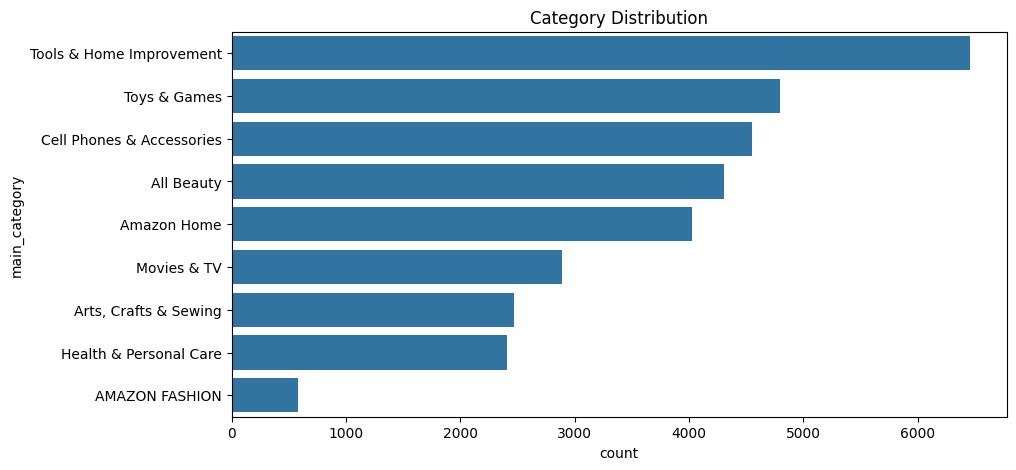

In [41]:
# EDA: Category distribution
plt.figure(figsize=(10, 5))
sns.countplot(y=data['main_category'], order=data['main_category'].value_counts().index)
plt.title('Category Distribution')
plt.show()

### Download the stopwords, wordnet and punkt from nltk

In [42]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Preprocessing
- Handle missing values by replacing them with column means.
- Split dataset into features (X) and target (y).
- Standardize the features for better model performance.

### Text Preprocessing

In [43]:
# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

data['processed_text'] = data['title'] + ' ' + data['description']
data['processed_text'] = data['processed_text'].apply(clean_text)

### Tokenization & Vectorization

In [44]:
# Tokenization & Vectorization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

### Label Encoding

In [45]:
# Label Encoding
category_mapping = {category: idx for idx, category in enumerate(data['main_category'].unique())}
data['category_encoded'] = data['main_category'].map(category_mapping)
y = to_categorical(data['category_encoded'])

### Train-Test Split

In [46]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

## Model Training
Using RandomForestClassifier to train the model.

### LSTM Model

In [48]:
# LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(len(category_mapping), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 99s 231ms/step - accuracy: 0.4708 - loss: 1.4859 - val_accuracy: 0.8444 - val_loss: 0.5414
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.8238 - loss: 0.5968 - val_accuracy: 0.8728 - val_loss: 0.4551
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 145s 243ms/step - accuracy: 0.8803 - loss: 0.4209 - val_accuracy: 0.8805 - val_loss: 0.4255
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 99s 243ms/step - accuracy: 0.9079 - loss: 0.3193 - val_accuracy: 0.8925 - val_loss: 0.4087
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 139s 235ms/step - accuracy: 0.9220 - loss: 0.2748 - val_accuracy: 0.8930 - val_loss: 0.4009


## Model Evaluation
- Predict the test set.
- Calculate accuracy and display classification report.

### Evaluate model

In [49]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.8944 - loss: 0.4069
Test Accuracy: 89.30%


### Test the model with a new description

In [50]:
# Test the model with a new description
new_description = 'Unveil a radiant, youthful complexion with our luxurious Elixir of Youth serum, a potent blend of hyaluronic acid and vitamin C that deeply hydrates, visibly plumps fine lines, and brightens skin tone for a rejuvenated appearance. Experience the silky smooth texture that absorbs instantly, leaving your face feeling refreshed and glowing with a healthy radiance.'
new_description = clean_text(new_description)
new_sequence = tokenizer.texts_to_sequences([new_description])
new_padded_sequence = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded_sequence)
predicted_category = data['main_category'].unique()[np.argmax(prediction)]
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
Predicted Category: All Beauty


### Save the model

In [51]:
# Save the model
model.save('final_model.keras')

### Save the tokenizer

In [52]:
# Save the tokenizer
import pickle
with open('final_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Save the category mapping

In [53]:
# Save the category mapping
with open('final_category_mapping.pickle', 'wb') as handle:
    pickle.dump(category_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Change directory to My Drive/Internship

In [29]:
# Change directory to My Drive/Internship
%cd /content/drive/My\ Drive/Internship

/content/drive/My Drive/Internship


### Load the model

In [54]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('final_model.keras')

### Load the tokenizer

In [55]:
# Load the tokenizer
with open('final_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Load the category mapping

In [56]:
# Load the category mapping
with open('final_category_mapping.pickle', 'rb') as handle:
    category_mapping = pickle.load(handle)

### Test the loaded model with a new description

In [57]:
# Test the loaded model with a new description
new_description = "The action-packed 'Mission Impossible - Dead Reckoning' features Tom Cruise performing death-defying stunts while prominently driving a sleek new BMW motorcycle, showcasing the brand's high-performance capabilities."
new_description = clean_text(new_description)
new_sequence = tokenizer.texts_to_sequences([new_description])
new_padded_sequence = pad_sequences(new_sequence, maxlen=100)
prediction = model.predict(new_padded_sequence)
predicted_category = list(category_mapping.keys())[np.argmax(prediction)]
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Predicted Category: Movies & TV


### Calculate all the classes for analysis

In [58]:
# Assuming y_pred contains the predicted categories for X_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step


### Calculate the Confusion Matrix

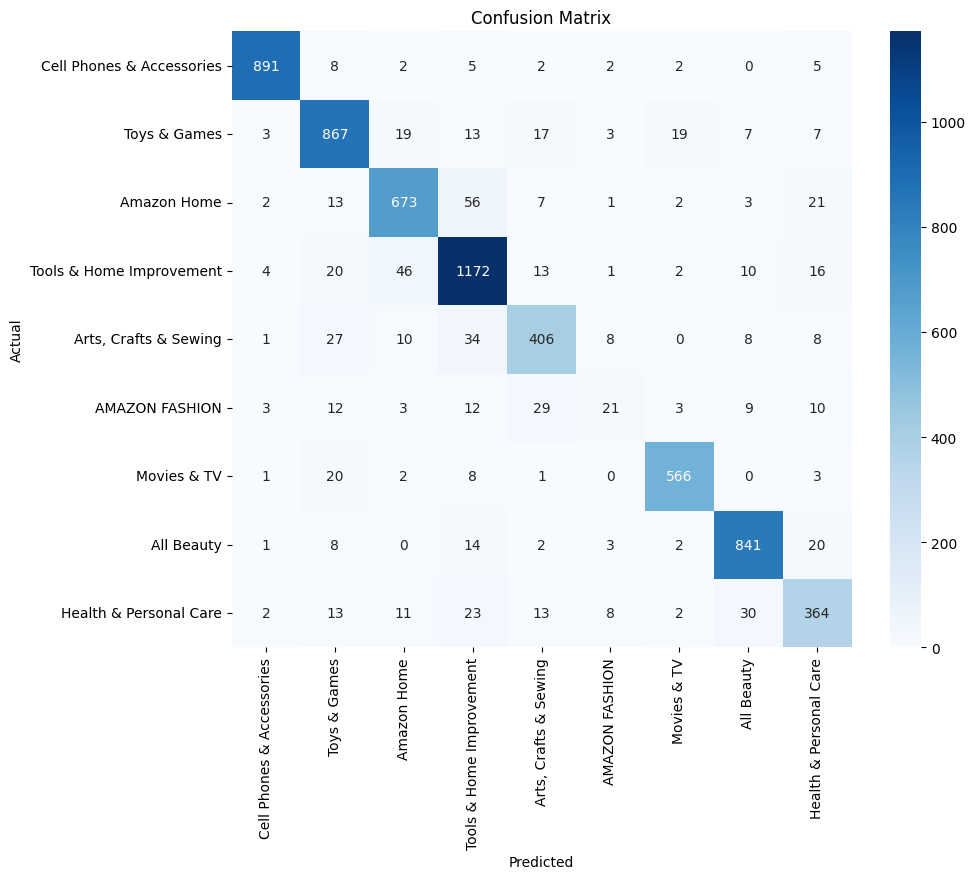

In [59]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(category_mapping.keys()),
            yticklabels=list(category_mapping.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Classification Report

In [60]:
# Classification Report (Recall, Precision, F1, Accuracy)
print(classification_report(y_true_classes, y_pred_classes, target_names=list(category_mapping.keys())))

                           precision    recall  f1-score   support

Cell Phones & Accessories       0.98      0.97      0.98       917
             Toys & Games       0.88      0.91      0.89       955
              Amazon Home       0.88      0.87      0.87       778
 Tools & Home Improvement       0.88      0.91      0.89      1284
    Arts, Crafts & Sewing       0.83      0.81      0.82       502
           AMAZON FASHION       0.45      0.21      0.28       102
              Movies & TV       0.95      0.94      0.94       601
               All Beauty       0.93      0.94      0.93       891
   Health & Personal Care       0.80      0.78      0.79       466

                 accuracy                           0.89      6496
                macro avg       0.84      0.82      0.82      6496
             weighted avg       0.89      0.89      0.89      6496



### Further EDA visualizations:
1. Word Clouds: Examine frequently occurring words for each category.
   This helps identify if certain categories have common terms that might cause bias.
2. Distribution of Text Length: Analyze the length of descriptions for each category. A significant variation in length might impact model performance.
3. N-gram Analysis: Identify frequent word pairs or triplets for each category to understand how they influence classification.
4. Explore relationships between other features (price, rating, etc.) and misclassifications.

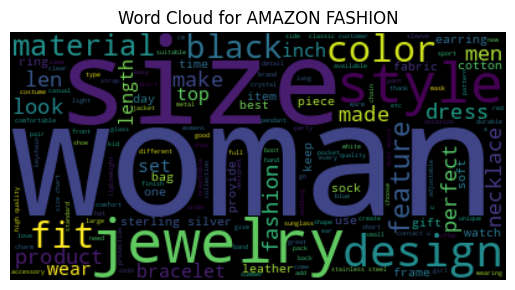

In [61]:
# Example: Word cloud for a specific category
from wordcloud import WordCloud

text = ' '.join(data[data['main_category'] == 'AMAZON FASHION']['processed_text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for AMAZON FASHION')
plt.show()

### Metric Calculation (Accuracy, Precision, Recall, F1-Score)

In [62]:
# Calculate metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8930110837438424
Precision: 0.8891916841728343
Recall: 0.8930110837438424
F1-score: 0.8902524331001063


### Error Analysis

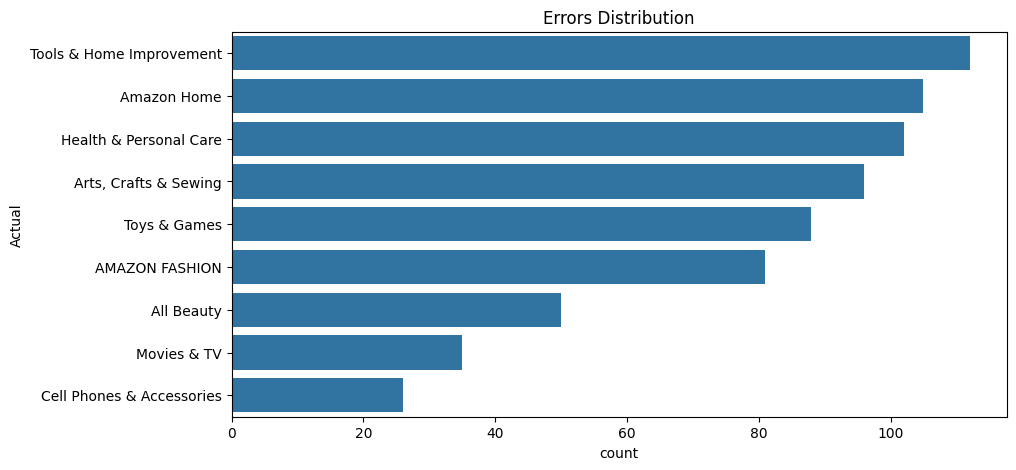

In [63]:
# Category Errors Analysis
category_errors = pd.DataFrame({'Actual': [list(category_mapping.keys())[i] for i in y_true_classes],
                                'Predicted': [list(category_mapping.keys())[i] for i in y_pred_classes]})
errors = category_errors[category_errors['Actual'] != category_errors['Predicted']]

plt.figure(figsize=(10, 5))
sns.countplot(y=errors['Actual'], order=errors['Actual'].value_counts().index)
plt.title('Errors Distribution')
plt.show()

### Skewness Check

In [64]:
# Create a cross-tabulation of actual vs. predicted categories
error_counts = pd.crosstab(errors['Actual'], errors['Predicted'])

In [65]:
# Function to get the top N misclassified categories
def get_top_misclassified(actual_category, n=3):
    misclassified = error_counts.loc[actual_category].drop(actual_category)
    # Sort first by absolute value, then by relative value
    sorted_misclassified = misclassified.sort_values(ascending=False, key=lambda x: abs(x))
    return sorted_misclassified.head(n)

In [66]:
# Iterate through each category and find the top misclassified categories
for category in category_mapping:
    top_misclassified = get_top_misclassified(category)
    print(f"Top misclassified categories for '{category}':")
    print(top_misclassified)
    print("-" * 20)

Top misclassified categories for 'Cell Phones & Accessories':
Predicted
Toys & Games                8
Health & Personal Care      5
Tools & Home Improvement    5
Name: Cell Phones & Accessories, dtype: int64
--------------------
Top misclassified categories for 'Toys & Games':
Predicted
Amazon Home              19
Movies & TV              19
Arts, Crafts & Sewing    17
Name: Toys & Games, dtype: int64
--------------------
Top misclassified categories for 'Amazon Home':
Predicted
Tools & Home Improvement    56
Health & Personal Care      21
Toys & Games                13
Name: Amazon Home, dtype: int64
--------------------
Top misclassified categories for 'Tools & Home Improvement':
Predicted
Amazon Home               46
Toys & Games              20
Health & Personal Care    16
Name: Tools & Home Improvement, dtype: int64
--------------------
Top misclassified categories for 'Arts, Crafts & Sewing':
Predicted
Tools & Home Improvement    34
Toys & Games                27
Amazon Home     

### More detailed error analysis can be performed here, e.g. calculating the percentage of errors per category.

In [ ]:
def get_top_misclassified_with_percentage(actual_category, n=3, threshold=5):
    misclassified = error_counts.loc[actual_category].drop(actual_category)

    sorted_misclassified = misclassified.sort_values(ascending=False, key=lambda x: abs(x))


    sorted_misclassified = sorted_misclassified[sorted_misclassified >= threshold]

    total_misclassified_for_category = sorted_misclassified.sum()

    if total_misclassified_for_category > 0:  # Check if there are misclassifications after thresholding
      relative_percentages = (sorted_misclassified / total_misclassified_for_category) * 100
      top_n = sorted_misclassified.head(n).index.tolist()
      top_n_percentages = relative_percentages[top_n]
      return top_n, top_n_percentages
    else:
        return [], {}

dropdown = widgets.Dropdown(
    options=[],
    description='Select Category:',
    disabled=False,
)

In [ ]:
def on_dropdown_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_category = change['new']
        top_categories, percentages = get_top_misclassified_with_percentage(selected_category)

        # Check if both top_categories and percentages are non-empty
        if top_categories and not percentages.empty:  # Use not percentages.empty to check for empty Series
            output_text = f"Top misclassified categories for '{selected_category}':\n"
            for cat, percentage in zip(top_categories, percentages):
                output_text += f"- {cat}: {percentage:.2f}%\n"
            print(output_text)

        else:
            print(f"No significant misclassifications for '{selected_category}' found above the threshold.")

dropdown.observe(on_dropdown_change)
display(dropdown)

In [72]:
# Populating the dropdown with unique category names from the category mapping
dropdown.options = list(category_mapping.keys())


Dropdown(description='Select Category:', options=(), value=None)

Top misclassified categories for 'Cell Phones & Accessories':
- Toys & Games: 44.44%
- Health & Personal Care: 27.78%
- Tools & Home Improvement: 27.78%

Top misclassified categories for 'Toys & Games':
- Amazon Home: 23.17%
- Movies & TV: 23.17%
- Arts, Crafts & Sewing: 20.73%

Top misclassified categories for 'Amazon Home':
- Tools & Home Improvement: 57.73%
- Health & Personal Care: 21.65%
- Toys & Games: 13.40%

Top misclassified categories for 'Tools & Home Improvement':
- Amazon Home: 43.81%
- Toys & Games: 19.05%
- Health & Personal Care: 15.24%

Top misclassified categories for 'Arts, Crafts & Sewing':
- Tools & Home Improvement: 35.79%
- Toys & Games: 28.42%
- Amazon Home: 10.53%

Top misclassified categories for 'AMAZON FASHION':
- Arts, Crafts & Sewing: 40.28%
- Tools & Home Improvement: 16.67%
- Toys & Games: 16.67%

Top misclassified categories for 'Movies & TV':
- Toys & Games: 71.43%
- Tools & Home Improvement: 28.57%

Top misclassified categories for 'All Beauty':
- Hea